<a href="https://colab.research.google.com/github/annshita/IoT-Anomaly-Detection-PCA/blob/main/PCA_nslkdd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('nsl_kdd.csv')

In [ ]:
data.shape

(125973, 42)

In [ ]:
data['class'] = data['class'].apply(lambda x: 1 if x == 0 else -1)

In [ ]:
data['service'].value_counts()

service
b'http'         40338
b'private'      21853
b'domain_u'      9043
b'smtp'          7313
b'ftp_data'      6860
                ...  
b'tftp_u'           3
b'http_8001'        2
b'aol'              2
b'harvest'          2
b'http_2784'        1
Name: count, Length: 70, dtype: int64

In [ ]:
data['flag'].value_counts()

flag
b'SF'        74945
b'S0'        34851
b'REJ'       11233
b'RSTR'       2421
b'RSTO'       1562
b'S1'          365
b'SH'          271
b'S2'          127
b'RSTOS0'      103
b'S3'           49
b'OTH'          46
Name: count, dtype: int64

In [ ]:
le = LabelEncoder()
data['service'] = le.fit_transform(data['service'])

In [ ]:
data['service'].value_counts()

service
24    40338
49    21853
12     9043
54     7313
20     6860
      ...  
61        3
27        2
3         2
22        2
25        1
Name: count, Length: 70, dtype: int64

In [ ]:
data['flag'] = le.fit_transform(data['flag'])

In [ ]:
data['flag'].value_counts()

flag
9     74945
5     34851
1     11233
4      2421
2      1562
6       365
10      271
7       127
3       103
8        49
0        46
Name: count, dtype: int64

In [ ]:
X = data.drop(columns=['class'])
y = data['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

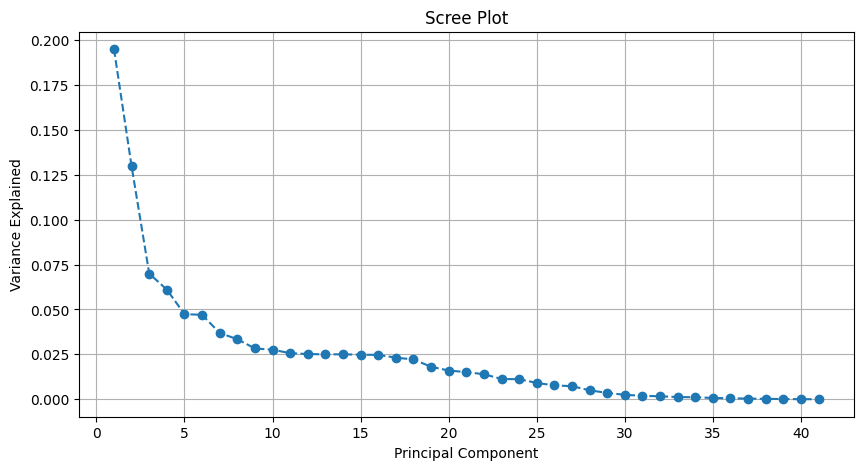

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid()
plt.show()

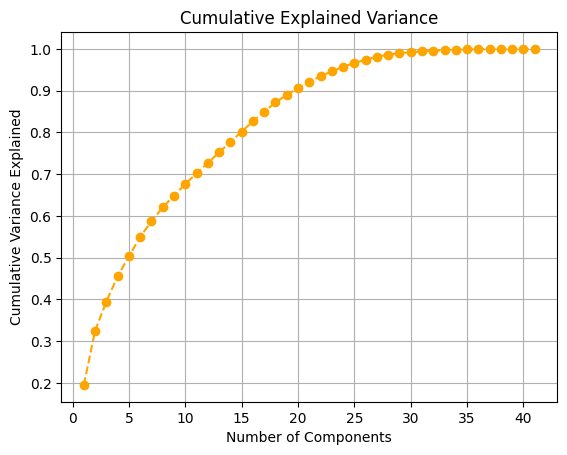

In [ ]:
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
variance_threshold = 0.90
n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Number of components to retain {variance_threshold*100}% variance: {n_components}")

Number of components to retain 90.0% variance: 20


In [ ]:
pca = PCA(n_components=20)
X_reduced_train = pca.fit_transform(X_train_scaled)
print(f"Shape of reduced data: {X_reduced_train.shape}")

Shape of reduced data: (100778, 20)


In [ ]:
pca = PCA(n_components=20)
X_reduced_test = pca.fit_transform(X_test_scaled)
print(f"Shape of reduced data: {X_reduced_test.shape}")

Shape of reduced data: (25195, 20)


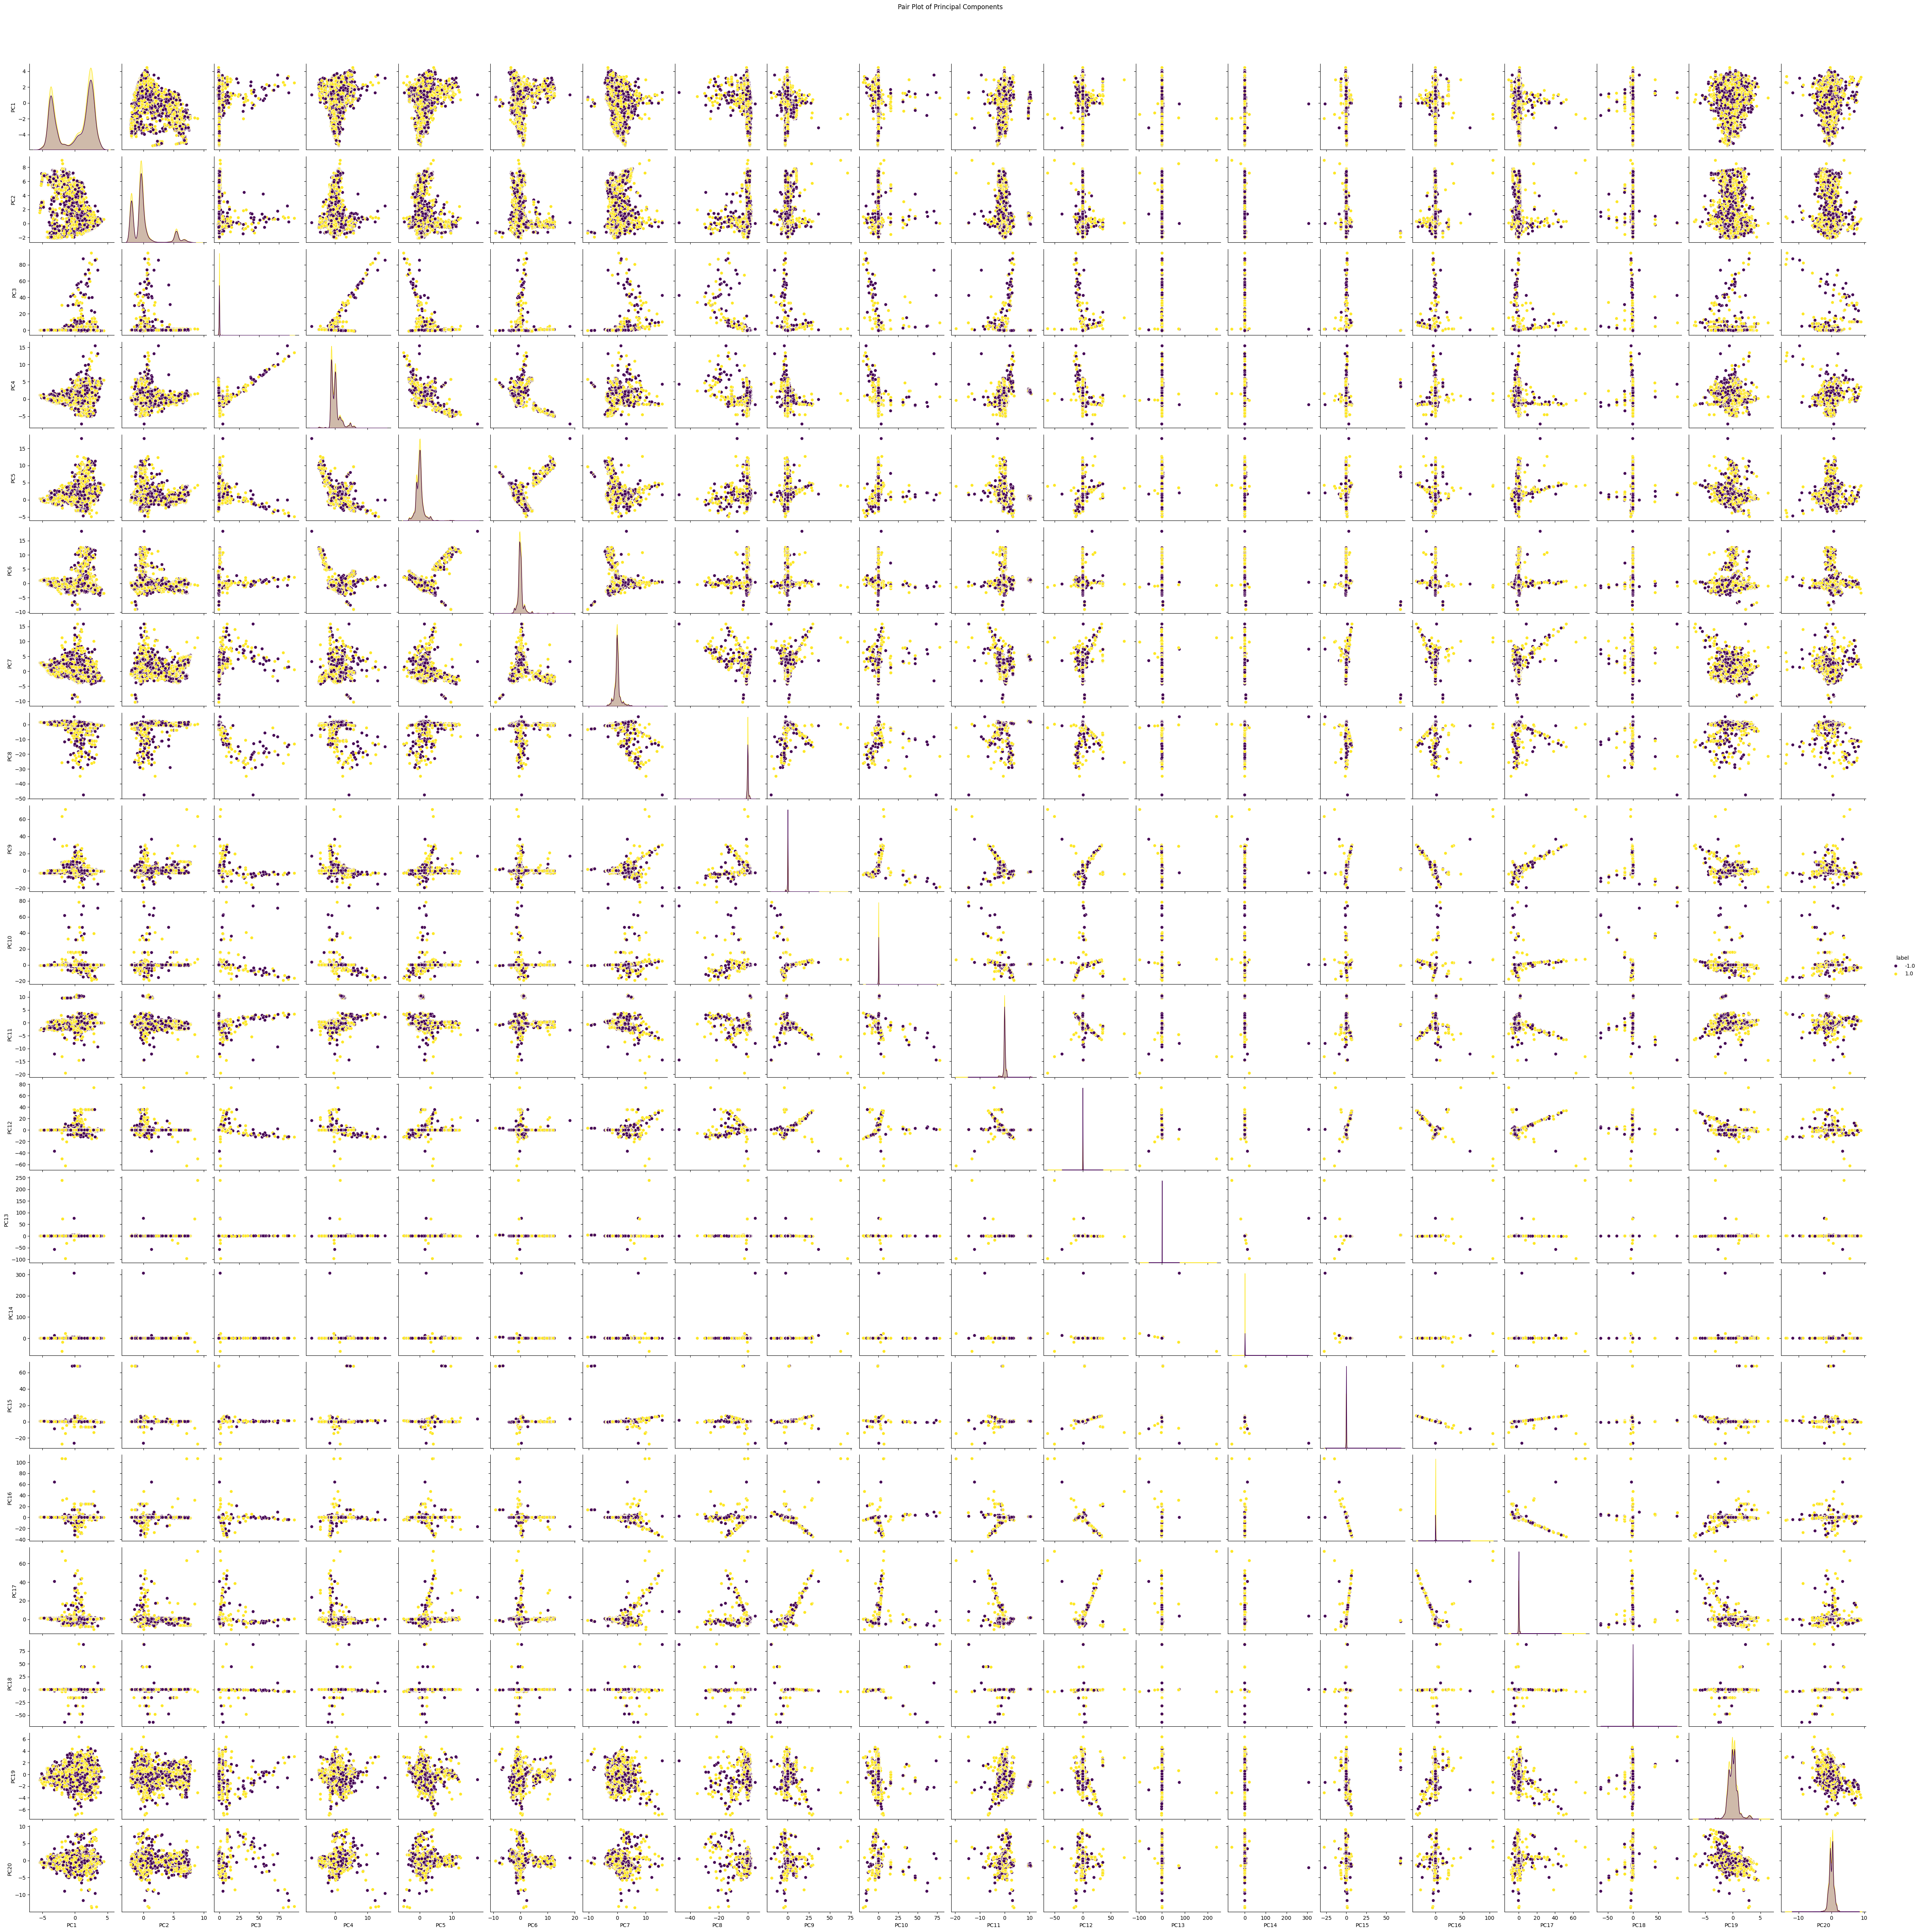

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
pca_df = pd.DataFrame(X_reduced_train, columns=[f'PC{i+1}' for i in range(X_reduced_train.shape[1])])
pca_df['label'] = y_train
sns.pairplot(pca_df, hue='label', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of Principal Components', y=1.02)
plt.show()

In [ ]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(X_reduced_train)
y_pred = ocsvm.predict(X_reduced_test)

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Precision: 0.56
Recall: 0.56
F1 Score: 0.56
Accuracy: 0.56
Classification Report:
               precision    recall  f1-score   support

          -1       0.53      0.51      0.52     11773
           1       0.58      0.61      0.60     13422

    accuracy                           0.56     25195
   macro avg       0.56      0.56      0.56     25195
weighted avg       0.56      0.56      0.56     25195



Mean Squared Error: 1.7548
AUC-ROC Score: 0.5579


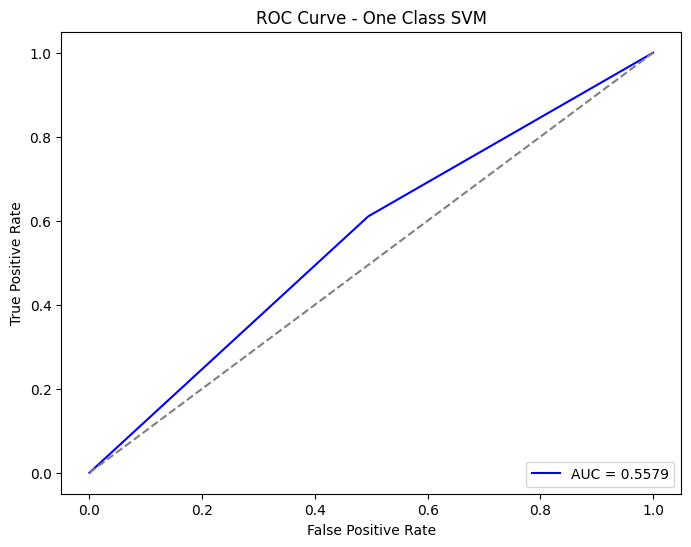

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One Class SVM")
plt.legend(loc="lower right")
plt.show()

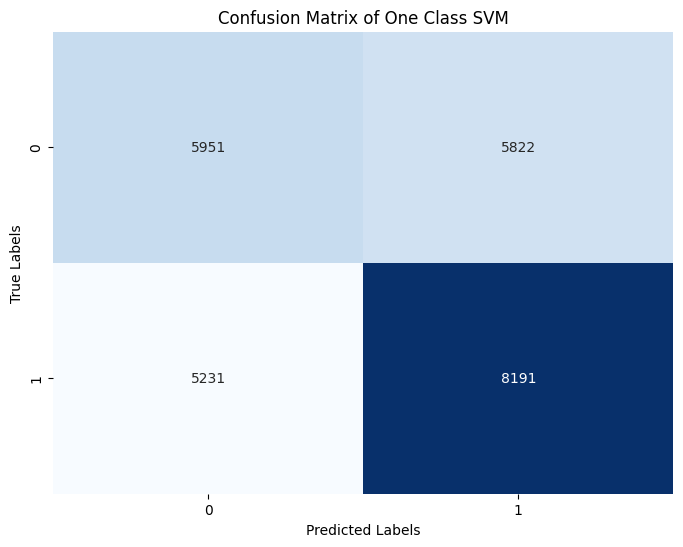

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of One Class SVM")
plt.show()

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_reduced_train, y_train)
y_pred_dt = dt_model.predict(X_reduced_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average='weighted')
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Decision Tree Performance:
Accuracy: 0.80
Precision: 0.81
Recall: 0.80
F1 Score: 0.80


Mean Squared Error: 0.7836
AUC-ROC Score: 0.7976


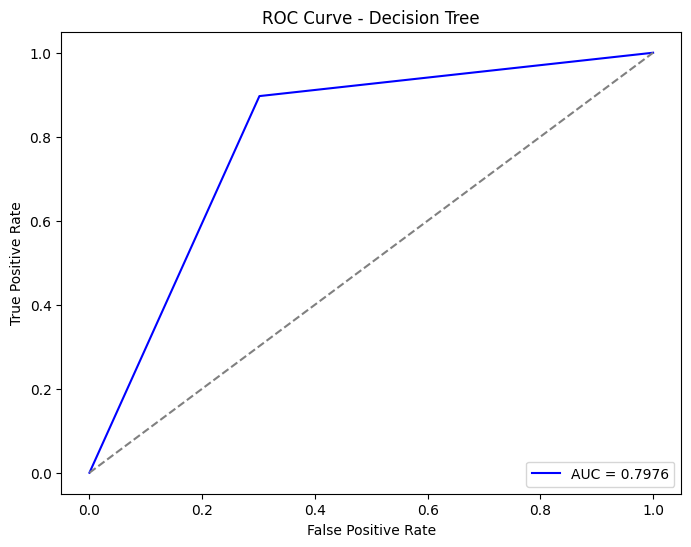

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
mse = mean_squared_error(y_test, y_pred_dt)
print(f"Mean Squared Error: {mse:.4f}")
auc_score = roc_auc_score(y_test, y_pred_dt)
print(f"AUC-ROC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

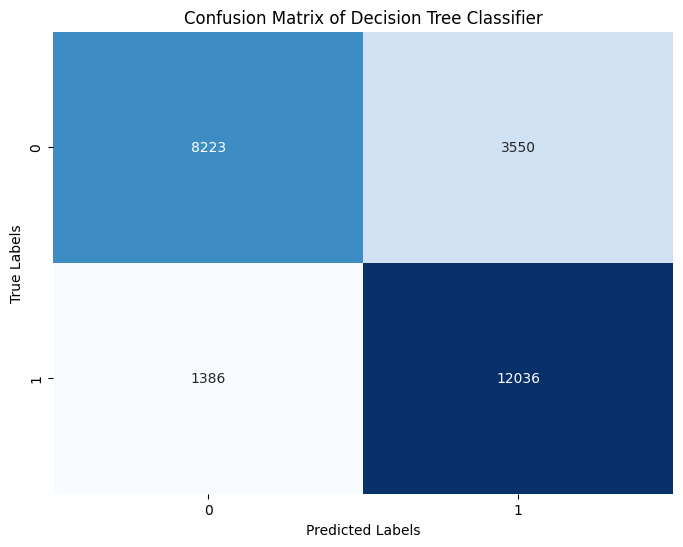

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Decision Tree Classifier")
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_reduced_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_knn = model.predict(X_reduced_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')
f1 = f1_score(y_test, y_pred_knn, average='weighted')
print("KNN:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

KNN:
Accuracy: 0.73
Precision: 0.75
Recall: 0.73
F1 Score: 0.73


Mean Squared Error: 1.0712
AUC-ROC Score: 0.7379


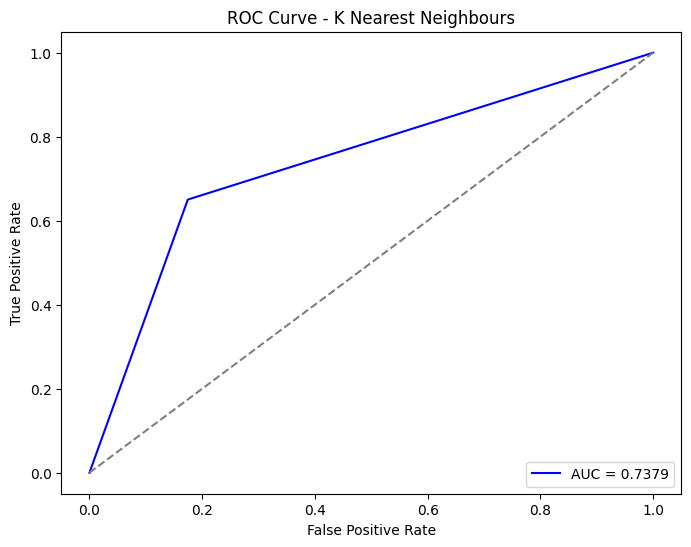

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
mse = mean_squared_error(y_test, y_pred_knn)
print(f"Mean Squared Error: {mse:.4f}")
auc_score = roc_auc_score(y_test, y_pred_knn)
print(f"AUC-ROC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - K Nearest Neighbours")
plt.legend(loc="lower right")
plt.show()

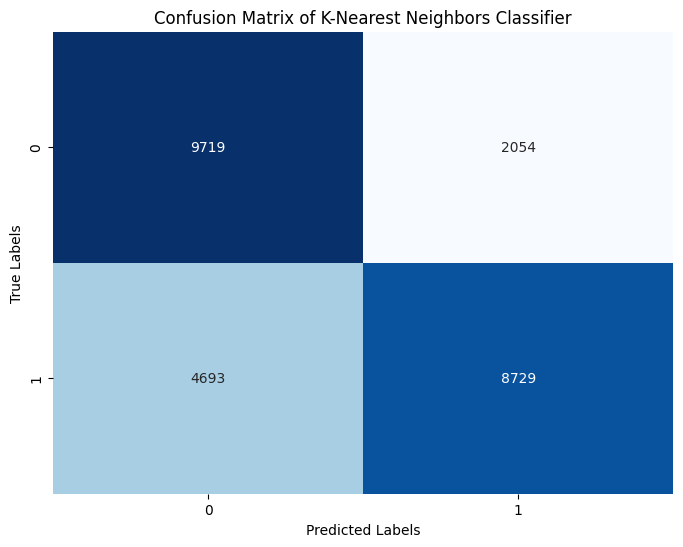

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of K-Nearest Neighbors Classifier")
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest
model = IsolationForest()
model.fit(X_reduced_train)

IsolationForest()

In [ ]:
y_pred_isofor=model.predict(X_reduced_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_isofor)
precision = precision_score(y_test, y_pred_isofor, average='weighted')
recall = recall_score(y_test, y_pred_isofor, average='weighted')
f1 = f1_score(y_test, y_pred_isofor, average='weighted')
print("Isolation Forest:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Isolation Forest:
Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1 Score: 0.56


Mean Squared Error: 1.7745
AUC-ROC Score: 0.5537


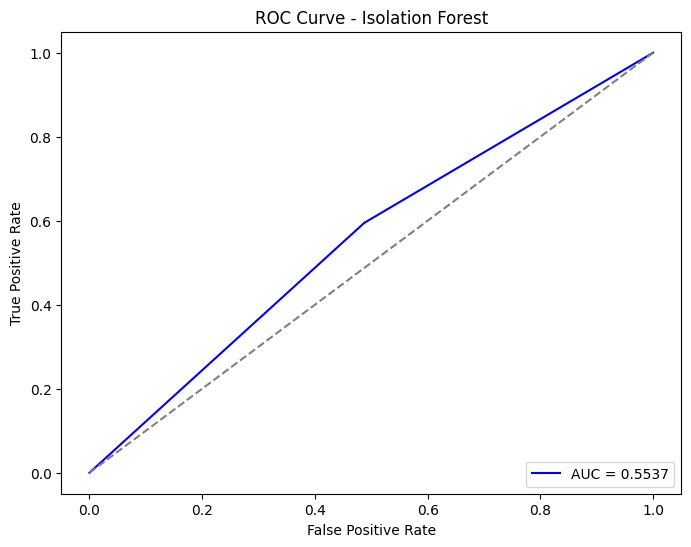

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
mse = mean_squared_error(y_test, y_pred_isofor)
print(f"Mean Squared Error: {mse:.4f}")
auc_score = roc_auc_score(y_test, y_pred_isofor)
print(f"AUC-ROC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_isofor)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.legend(loc="lower right")
plt.show()

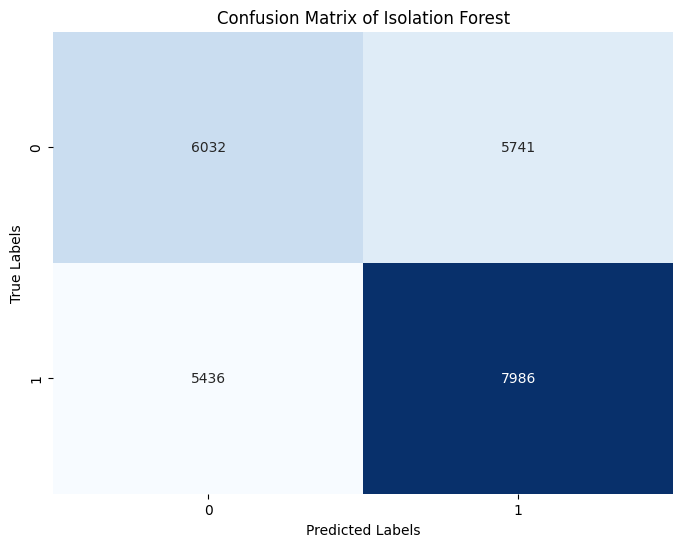

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_isofor)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Isolation Forest")
plt.show()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_reduced_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
precision = precision_score(y_test, y_pred_lof, pos_label=-1)
recall = recall_score(y_test, y_pred_lof, pos_label=-1)
f1 = f1_score(y_test, y_pred_lof, pos_label=-1)
accuracy = accuracy_score(y_test, y_pred_lof)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lof))

Precision: 0.30198412698412697
Recall: 0.0646394292024123
F1 Score: 0.10648569229692857
Accuracy: 0.49311371303830126

Classification Report:
               precision    recall  f1-score   support

          -1       0.30      0.06      0.11     11773
           1       0.51      0.87      0.65     13422

    accuracy                           0.49     25195
   macro avg       0.41      0.47      0.38     25195
weighted avg       0.42      0.49      0.39     25195



Mean Squared Error: 2.0275
AUC-ROC Score: 0.4668


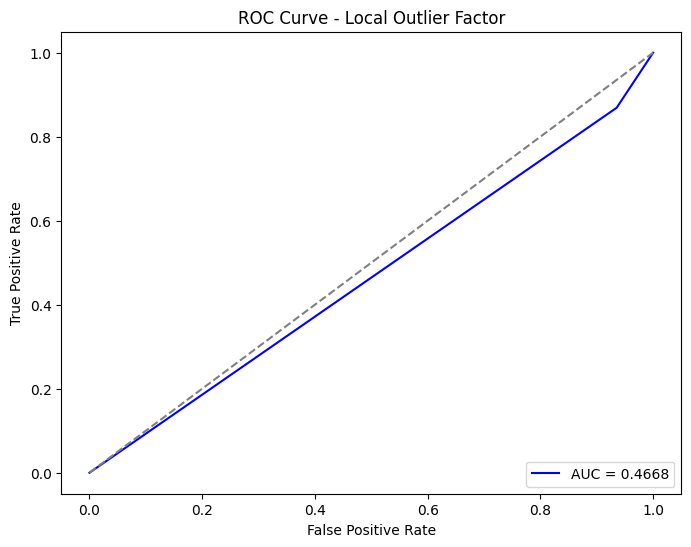

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
mse = mean_squared_error(y_test, y_pred_lof)
print(f"Mean Squared Error: {mse:.4f}")
auc_score = roc_auc_score(y_test, y_pred_lof)
print(f"AUC-ROC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lof)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Local Outlier Factor")
plt.legend(loc="lower right")
plt.show()

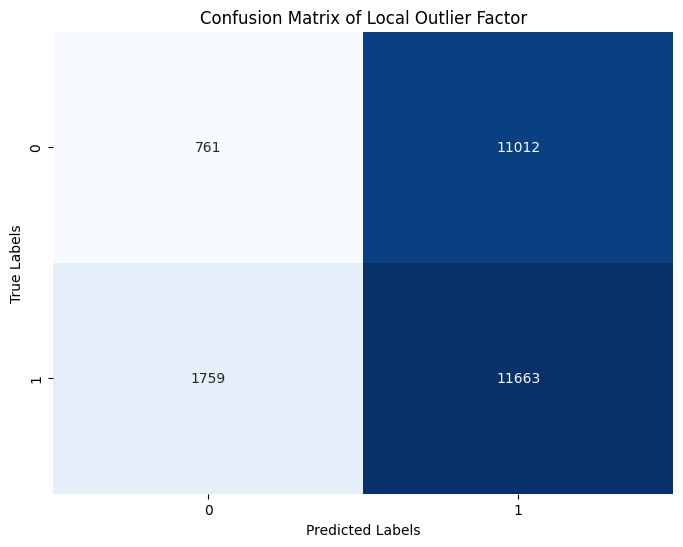

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lof)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Local Outlier Factor")
plt.show()